In [1]:
# imports 
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.text import TSNEVisualizer
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

plt.style.use('ggplot')
rcParams['figure.figsize'] = (12,6)

#### Prepare

In [9]:
data_dir = 'data/'

In [10]:
# load data
lyrics = pd.read_csv(data_dir + 'clean_lyrics_df.csv', index_col='Unnamed: 0')
artist = pd.read_csv(data_dir + 'artists-data.csv')

lyrics['ALink'] = lyrics['ALink'].apply(lambda x: f'/{x.replace(" ","-")}/')

df = lyrics.merge(artist, left_on='ALink', right_on='Link')
df.drop(df[df['language']!='en'].index, inplace=True)
df.drop(['ALink','SLink','Link','language','features'], axis=1, inplace=True)
df.rename(columns={'SName': 'Title'}, inplace=True)
df.head()

,Title,Lyric,Artist,Genres,Songs,Popularity
0,In da Club,"go, go, go, go\ngo, go, go shawty\nit's your b...",50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
1,21 Questions,new york city!\nyou are now rapping...with 50 ...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
2,P.I.M.P.,i don't know what you heard about me\nbut a b*...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
3,Many Men (Wish Death),man we gotta go get something to eat man\ni'm ...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7
4,Candy Shop,yeah...\nuh huh\nso seductive\ni'll take you t...,50 Cent,Hip Hop; Rap; Black Music,469.0,40.7


In [12]:
df[df['Lyric'].str.startswith('shortcut to part of bill monroe')]

,Title,Lyric,Artist,Genres,Songs,Popularity
7309,Along About Daybreak,shortcut to part of bill monroe lyrics\nbill m...,Bill Monroe,Country; Black Music,351.0,0.0
7310,An Angel In Disguise,shortcut to part of bill monroe lyrics\nbill m...,Bill Monroe,Country; Black Music,351.0,0.0
7313,Are You Lost In Sin?,shortcut to part of bill monroe lyrics\nbill m...,Bill Monroe,Country; Black Music,351.0,0.0
7314,Ashland Breakdown,shortcut to part of bill monroe lyrics\nbill m...,Bill Monroe,Country; Black Music,351.0,0.0
7315,Back Up And Push,shortcut to part of bill monroe lyrics\nbill m...,Bill Monroe,Country; Black Music,351.0,0.0
...,...,...,...,...,...,...
7647,Working On A Building,shortcut to part of bill monroe lyrics\nbill m...,Bill Monroe,Country; Black Music,351.0,0.0
7648,Y'all Come,shortcut to part of bill monroe lyrics\nbill m...,Bill Monroe,Country; Black Music,351.0,0.0
7649,You Live In A World All Your Own,shortcut to part of bill monroe lyrics\nbill m...,Bill Monroe,Country; Black Music,351.0,0.0
7650,You Won't Be Satisfied That Way,shortcut to part of bill monroe lyrics\nbill m...,Bill Monroe,Country; Black Music,351.0,0.0


#### Explore

Holistic Exploration

In [13]:
df.tail()

,Title,Lyric,Artist,Genres,Songs,Popularity
14323,You Oughta Be Home With Me,"everybody's here, spinnin' the bottle\neverybo...",Barry Manilow,Romântico,330.0,0.0
14324,You're Leaving Too Soon,you're leavin' too soon\nyou oughta try believ...,Barry Manilow,Romântico,330.0,0.0
14325,You're Looking Hot Tonight,you're looking hot tonight\nbarry manilow\nby:...,Barry Manilow,Romântico,330.0,0.0
14326,You're There,our friends all use the past tense when they s...,Barry Manilow,Romântico,330.0,0.0
14327,Young At Heart,"fairy tales can come true, it can happen to yo...",Barry Manilow,Romântico,330.0,0.0


In [14]:
df.shape

(14328, 6)

In [15]:
df.describe(include='all')

,Title,Lyric,Artist,Genres,Songs,Popularity
count,14328,14328,14328,14328,14328.000000,14328.000000
unique,13180,14002,32,28,NaN,NaN
top,White Christmas,shortcut to part of bill monroe lyrics\nbill m...,Frank Sinatra,Country,NaN,NaN
freq,9,41,818,1451,NaN,NaN
mean,NaN,NaN,NaN,NaN,512.620394,12.696189
std,NaN,NaN,NaN,NaN,151.695441,22.559706
min,NaN,NaN,NaN,NaN,323.000000,0.000000
25%,NaN,NaN,NaN,NaN,376.000000,1.300000
50%,NaN,NaN,NaN,NaN,494.000000,3.300000
75%,NaN,NaN,NaN,NaN,621.000000,14.100000


In [16]:
df.drop_duplicates(subset='Lyric', keep=False, inplace=True)
df.shape

(13870, 6)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13870 entries, 0 to 14327
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       13870 non-null  object 
 1   Lyric       13870 non-null  object 
 2   Artist      13870 non-null  object 
 3   Genres      13870 non-null  object 
 4   Songs       13870 non-null  float64
 5   Popularity  13870 non-null  float64
dtypes: float64(2), object(4)
memory usage: 758.5+ KB


Individual Variable Exploration

In [18]:
df['Genres'].value_counts(normalize=True)

Country                         0.102740
Hip Hop; Rap; Black Music       0.080894
Jazz; Clássico; Romântico       0.057390
Rockabilly; Romântico; Rock     0.053569
Indie                           0.043043
R&B; Black Music; Funk          0.040087
R&B; Black Music; Rap           0.038933
Folk; Rock; Country             0.038861
Folk; Country; Rock             0.038572
Country; Folk                   0.038284
Rock; Folk                      0.036698
Rock                            0.035977
Rap; Hip Hop; Pop               0.034679
Rockabilly                      0.031218
Hip Hop; Rap                    0.028335
Jazz                            0.028262
Blues                           0.026532
Hard Rock; Rock; Pop/Rock       0.026316
Pop; Romântico; Pop/Rock        0.025883
R&B; Soul Music; Disco          0.024946
Dance; Pop                      0.024730
Romântico                       0.023648
Surf Music; Rock                0.023648
Rock; Hard Rock; Heavy Metal    0.023432
Indie; Rock     

In [19]:
df['Songs'].describe()

count    13870.000000
mean       515.314924
std        151.397113
min        323.000000
25%        378.000000
50%        505.000000
75%        621.000000
max        828.000000
Name: Songs, dtype: float64

In [20]:
df['Popularity'].describe()

count    13870.000000
mean        12.985984
std         22.803892
min          0.000000
25%          1.300000
50%          3.300000
75%         14.100000
max        114.900000
Name: Popularity, dtype: float64

In [21]:
# Normalize popularity
df['PopNorm'] = (df['Popularity'] - df['Popularity'].min()) / (df['Popularity'].max() - df['Popularity'].min())
df['PopNorm'].describe()

count    13870.000000
mean         0.113020
std          0.198467
min          0.000000
25%          0.011314
50%          0.028721
75%          0.122715
max          1.000000
Name: PopNorm, dtype: float64

Bivariate Exploration

In [22]:
df['Genre_1'] = df['Genres'].apply(lambda x: x.split(';')[0])
top_5_genres = df.groupby('Genre_1')['Title'].count().sort_values(ascending=False).reset_index()['Genre_1'][:10]

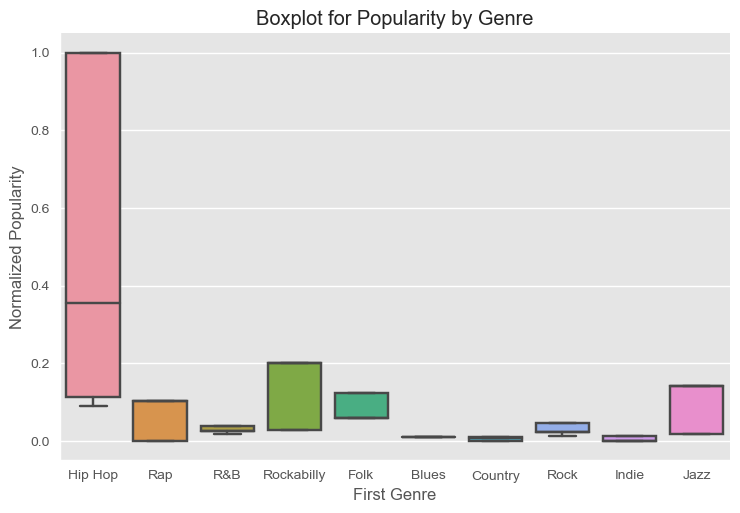

Not very instructive...


In [26]:
sns.catplot(x='Genre_1', y='PopNorm', data=df[df['Genre_1'].isin(top_5_genres)], kind='box', aspect=1.5)
plt.title("Boxplot for Popularity by Genre")
plt.xlabel('First Genre')
plt.ylabel('Normalized Popularity')
plt.show()
print('Not very instructive...')

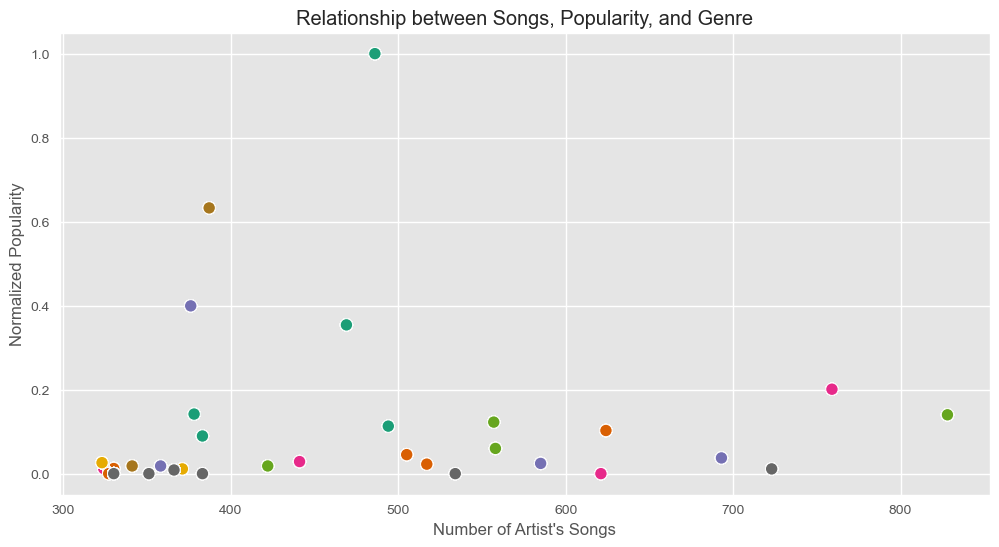

In [27]:
sns.scatterplot(x="Songs", y="PopNorm", hue="Genre_1", data=df, palette="Dark2", s=80, legend=False)
plt.title("Relationship between Songs, Popularity, and Genre")
plt.xlabel('Number of Artist\'s Songs')
plt.ylabel('Normalized Popularity')
plt.show()